In [234]:
import pickle
import pandas


def Merge(dict1, dict2):
    return (dict1.update(dict2))


def create_list_dict():
    return []


def change_keys(dictionary, key_transform_func):
    return {key_transform_func(key): value for key, value in dictionary.items()}


def add_file_variable_name(key, i):
    return tuple(list(key) + [i])


track_history_paths = [f"pickle/track_history_amsterdam_full_000{i}.mp4.pkl" for i in range(7)]
track_histories = []
track_histories_sum = {}

for counter, track_history_path in enumerate(track_history_paths):
    print(f"Loading {track_history_path}")
    with open(track_history_path, 'rb') as file:
        dict_with_changed_keys = change_keys(pickle.load(file), lambda x: add_file_variable_name(x, counter))
        track_histories.append(dict_with_changed_keys)
#     
# with open(track_history_path2, 'rb') as file:
#     track_history2 = pickle.load(file)


Loading pickle/track_history_amsterdam_full_0000.mp4.pkl
Loading pickle/track_history_amsterdam_full_0001.mp4.pkl
Loading pickle/track_history_amsterdam_full_0002.mp4.pkl
Loading pickle/track_history_amsterdam_full_0003.mp4.pkl
Loading pickle/track_history_amsterdam_full_0004.mp4.pkl
Loading pickle/track_history_amsterdam_full_0005.mp4.pkl
Loading pickle/track_history_amsterdam_full_0006.mp4.pkl


In [235]:
for track_history in track_histories:
    Merge(track_histories_sum, track_history)

In [236]:
# track_histories_sum[(2668, 'person', 6)]
test_track_histories = []
test_track_keys = [(2470, 'truck', 6),
                   (2410, 'person', 6),
                   (555, 'motorcycle', 6),
                   (492, 'car', 6),
                   (85, 'person', 6),
                   (3690, 'car', 5),
                   (3539, 'person', 5)]
for test_track_key in test_track_keys:
    test_track_histories.append(track_histories_sum[test_track_key])
    del track_histories_sum[test_track_key]

In [237]:
len(track_histories_sum.keys())
s = 0
for key in track_histories_sum.keys():
    s += len(track_histories_sum[key])
print(s)

1285342


In [239]:
import numpy as np

track_histories_sum_numpy = [np.array(v) for k, v in track_histories_sum.items()]
test_track_histories_numpy = [np.array(v) for v in test_track_histories]

In [240]:
print("Train: ", len(track_histories_sum_numpy))
print("Test: ", len(test_track_histories_numpy))


Train:  18161
Test:  7


In [ ]:
import src.rnn as rnn
import importlib

importlib.reload(rnn)
# Hyperparameters
learning_rate = 0.001
epochs = 100
input_dim = 1  # Assuming only closing price is used
hidden_dim = 32
num_layers = 1
sequence_length = 60  # Number of past days used for prediction


def generate_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        target = data[i + sequence_length]
        concat_array = np.concatenate((seq, target.reshape(-1, 2)))
        sequences.append(concat_array)
    return np.array(sequences)


In [ ]:
sequences = []
for track_history in track_histories_sum_numpy:
    generated_sequences = generate_sequences(track_history, 10)
    if len(generated_sequences) > 0:
        sequences.append(generated_sequences)
sequences = np.concatenate([seq[:] for seq in sequences], axis=0)

test_sequences = []
for track_history in test_track_histories:
    generated_sequences = generate_sequences(track_history, 10)
    if len(generated_sequences) > 0:
        test_sequences.append(generated_sequences)
test_sequences = np.concatenate([seq[:] for seq in test_sequences], axis=0)


In [ ]:
test_sequences.shape

In [193]:
import numpy as np
import torch
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Hyperparameters
learning_rate = 0.001
epochs = 100
input_dim = 2  # Assuming only closing price is used
hidden_dim = 32
num_layers = 1
sequence_length = 60  # Number of past days used for prediction

# test_data = torch.tensor(test_sequences)
# Convert data to tensors
train_data = torch.tensor(sequences)
test_data = torch.tensor(test_sequences)

train_dataset = TensorDataset(train_data[:, :-1], train_data[:, -1])
test_dataset = TensorDataset(test_data[:, :-1], test_data[:, -1])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# 
model = rnn.LSTMModel(input_dim, hidden_dim, num_layers, 2)
# 
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_list = []
test_loss_list = []

test_loss = rnn.evaluate_model(model, test_loader, criterion)
print("Test loss: ", test_loss)
test_loss_list.append(test_loss)

for epoch in range(epochs):
    counter = 0
    model.train()
    for data, target in train_loader:
        outputs = model(data)
        loss = criterion(outputs, target)
        loss_list.append(loss.item())
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training progress (optional)
        if (counter + 1) % 1 == 0:  # Print every 100 mini-batches
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{counter + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        counter += 1
    test_loss = rnn.evaluate_model(model, test_loader, criterion)
    print("Test loss: ", test_loss)
    test_loss_list.append(test_loss)
    if epoch == 2:
        break




torch.Size([128, 10, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 10, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 10, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 10, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 10, 2])
torch.Size([128, 2])
torch.Size([128, 2])
Test loss:  224584.64375
Epoch [1/100], Step [1/8818], Loss: 347656.7812
Epoch [1/100], Step [2/8818], Loss: 394364.2188
Epoch [1/100], Step [3/8818], Loss: 355640.2500
Epoch [1/100], Step [4/8818], Loss: 366471.6250
Epoch [1/100], Step [5/8818], Loss: 334902.6562
Epoch [1/100], Step [6/8818], Loss: 383317.5312
Epoch [1/100], Step [7/8818], Loss: 353962.6875
Epoch [1/100], Step [8/8818], Loss: 326786.0625
Epoch [1/100], Step [9/8818], Loss: 310184.9375
Epoch [1/100], Step [10/8818], Loss: 364336.5312
Epoch [1/100], Step [11/8818], Loss: 315094.0312
Epoch [1/100], Step [12/8818], Loss: 364638.3438
Epoch [1/100], Step [13/8818], Loss: 397271.5000
Epoch [1/100

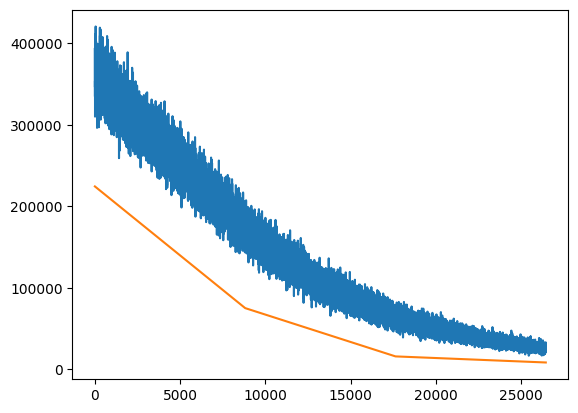

In [196]:
plt.plot(np.arange(len(loss_list)), loss_list)
plt.plot(np.arange(0, len(loss_list) + 1, len(train_loader)), test_loss_list)
# plt.figure()
# plt.plot(test_loss_list)

In [254]:
import src.predictorinterface as predictorinterface
test_track_histories = []
test_track_keys = [
    (1642, 'bicycle', 2),
    (1049, 'person', 4),
    (3059, 'person', 0),
    (449, 'bicycle', 5),
    (1241, 'motorcycle', 0),
    (645, 'umbrella', 0),
    (1101, 'person', 3),
    (430, 'car', 3),
    (685, 'bench', 1),
    (1194, 'chair', 6),
    (3225, 'person', 5)
]
seq_len=10
print(track_histories_sum.keys())
for test_track_key in test_track_keys:
    test_track_histories.append(track_histories_sum[test_track_key])
    # del track_histories_sum[test_track_key]
    
test_track_histories_numpy = [np.array(v) for v in test_track_histories]

s = 0
for test_track_element in test_track_histories_numpy:
    s += len(test_track_element) 
print("Test set point number: ", s)

test_sequences = []
for track_history in test_track_histories_numpy:
    generated_sequences = generate_sequences(track_history, seq_len)
    if len(generated_sequences) > 0:
        test_sequences.append(generated_sequences)
test_sequences = np.concatenate([seq[:] for seq in test_sequences], axis=0)

scaler_test = predictorinterface.MinMaxScalerCustom(-1, 1)
test_data = torch.tensor(test_sequences)
scaler_test.fit(test_data)
scaler_test.transform(test_data)
test_dataset = TensorDataset(test_data[:, :-1], test_data[:, -1])
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


dict_keys([(1, 'person', 0), (1, 'elephant', 0), (1, 'bear', 0), (2, 'person', 0), (3, 'person', 0), (4, 'person', 0), (5, 'person', 0), (6, 'person', 0), (7, 'person', 0), (10, 'person', 0), (12, 'traffic light', 0), (13, 'person', 0), (1, 'cow', 0), (15, 'bus', 0), (15, 'train', 0), (16, 'person', 0), (17, 'bus', 0), (18, 'person', 0), (19, 'person', 0), (20, 'person', 0), (21, 'person', 0), (24, 'person', 0), (25, 'person', 0), (28, 'person', 0), (29, 'person', 0), (30, 'person', 0), (31, 'bus', 0), (32, 'person', 0), (33, 'person', 0), (34, 'person', 0), (35, 'person', 0), (36, 'person', 0), (31, 'train', 0), (38, 'bench', 0), (39, 'bench', 0), (41, 'person', 0), (42, 'handbag', 0), (42, 'person', 0), (44, 'handbag', 0), (42, 'backpack', 0), (45, 'person', 0), (46, 'person', 0), (47, 'person', 0), (48, 'bench', 0), (44, 'backpack', 0), (49, 'person', 0), (50, 'traffic light', 0), (51, 'bicycle', 0), (52, 'bench', 0), (53, 'person', 0), (54, 'person', 0), (58, 'bicycle', 0), (59, 'b

In [273]:
# Step 1: Define the model architecture
import importlib
importlib.reload(rnn)
model = rnn.LSTMModel(2, 32, 3, 2)

# Step 2: Load saved weights
model.load_state_dict(torch.load('/Users/asif/progs/02-uni/05-advanced-proj-wang/custom-yolo/finetuning/exp_lstm_3_32_epochs_50_0.001_2024-05-09_10_30_57/final.pth'))
test_loss, (test_loss_x, test_loss_y) = rnn.evaluate_model(model, test_loader, criterion)

print("Test loss: ", test_loss)
print("Test loss x: ", test_loss_x)
print("Test loss y: ", test_loss_y)


Test loss:  22.61072769165039
Test loss x:  35.282281970977785
Test loss y:  9.93917112350464
